# Dataset Preparation

# Imports

In [21]:
# Import libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, random_split, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import Resize, InterpolationMode
import torchaudio
from torchsummary import summary
from torchmetrics import Accuracy, Precision, Recall, F1Score
from torchaudio.transforms import MelSpectrogram, FrequencyMasking
import librosa
import wandb
import cv2
from tqdm import tqdm
from pathlib import Path
from os import listdir, scandir

# Helper functions

In [2]:
def plot_spectogram(specgram, title=None, ylabel='freq_bin'):
    _, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin='lower', aspect='auto')

def plot_history(history, net_name):
    x_ticks = range(1, len(history['train']['loss']) + 1)
    for item in history['train'].keys():
        plt.figure(figsize=(12, 4))
        for prefix, color in zip(['train', 'val'], ['r', 'b']):
            plt.plot(x_ticks, history[prefix][item], c=color, alpha=0.75, linestyle='--',
                     label=prefix)
        plt.title('{} {}'.format(net_name, item))
        plt.xlabel('Epoch')
        plt.xticks(x_ticks)
        plt.ylabel(item)
        plt.grid()
        plt.legend()
        plt.show()

def plot_metric_values(metric_values, net_name):
    for item in metric_values:
        fig, ax = plt.subplots(figsize=(12, 4))
        x = range(metric_values[item].shape[0])
        mean = metric_values[item].mean()
        bars = ax.bar(x, metric_values[item])
        
        ax.axhline(mean, color='r', linestyle=':')
        for bar in bars:
            height = bar.get_height()
            
            ax.text(bar.get_x() + bar.get_width() / 2, height, '{:.2}'.format(height),
                    ha='center', va='bottom')
        ax.set_xlabel('Class')
        ax.set_xticks(x)
        ax.set_title('{} {} on test'.format(net_name, item))
        plt.show()

# Start preparing dataset

In [3]:
workdir_path = Path('../data')
sample_rate = 48000

data = []
with scandir(workdir_path) as entries:
    for entry in entries:
        if entry.is_dir():
            path_to_dir = workdir_path / entry.name

            for filename in listdir(path_to_dir):
                path_to_audio = path_to_dir / filename

                data.append((path_to_audio, int(filename[0])))

audio_df = pd.DataFrame(data, columns=['path_to_audio', 'class'])

audio_df

,path_to_audio,class
0,../data/59/7_59_29.wav,7
1,../data/59/7_59_15.wav,7
2,../data/59/2_59_1.wav,2
3,../data/59/3_59_1.wav,3
4,../data/59/9_59_22.wav,9
...,...,...
29995,../data/25/5_25_27.wav,5
29996,../data/25/5_25_33.wav,5
29997,../data/25/7_25_2.wav,7
29998,../data/25/6_25_2.wav,6


In [4]:
n_classes = audio_df['class'].max() + 1
print(f'There are {n_classes} classes in the dataset')

There are 10 classes in the dataset


# Create dataset

In [5]:
n_channels = 1
n_mels = 24
time = 48

transform = torch.nn.Sequential(
    MelSpectrogram(sample_rate, n_fft=1024, n_mels=n_mels),
    Resize(size=(n_mels, time), interpolation=InterpolationMode.NEAREST)
)

sample_bilateral.shape: torch.Size([1, 24, 48]), sample_bilateral.class: 7


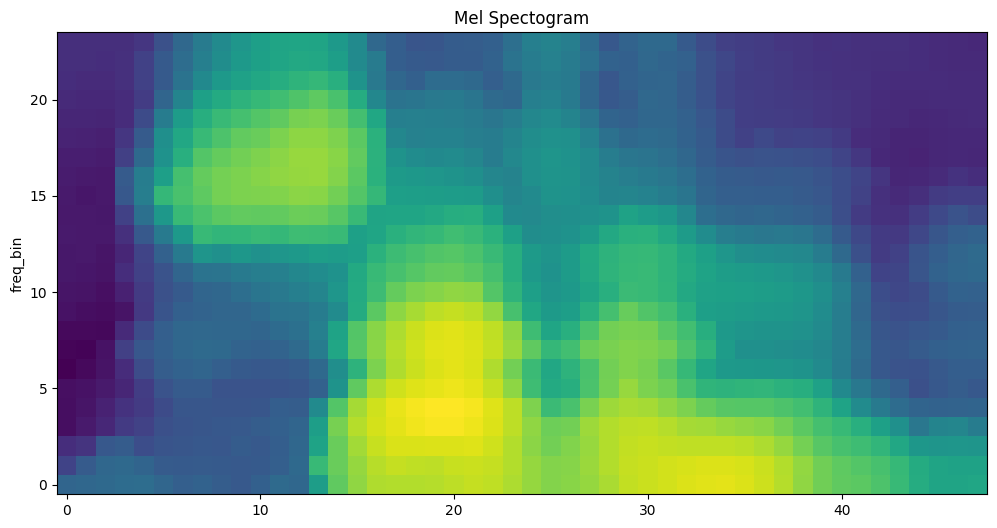

In [6]:
class BilateralAudioDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform
        self.d = 5
        self.sigmaColor = 10
        self.sigmaSpace = 10

    def __getitem__(self, i):
        path_to_audio, class_label = self.df.iloc[i]
        waveform, _ = torchaudio.load(path_to_audio, normalize=True)

        specgram = self.transform(waveform)

        specgram = self.apply_filter(specgram)

        return specgram, class_label

    def __len__(self):
        return self.df.shape[0]

    def apply_filter(self, specgram):
        filtered_channels = []
        for channel in range(specgram.shape[0]):
            specgram_channel_np = specgram[channel].numpy()
            filtered_channel_np = cv2.bilateralFilter(
                specgram_channel_np.astype(np.float32),
                self.d,
                self.sigmaColor,
                self.sigmaSpace,
            )
            filtered_channels.append(torch.from_numpy(filtered_channel_np))
            filtered_specgram = torch.stack(filtered_channels)
            
        return filtered_specgram

ds = BilateralAudioDataset(audio_df, transform)
sample_bilateral = ds[0]
plot_spectogram(sample_bilateral[0][0], 'Mel Spectogram')
print(f'sample_bilateral.shape: {sample_bilateral[0].shape}, sample_bilateral.class: {sample_bilateral[1]}')
plt.savefig('sample_bilateral.png')


In [7]:
batch_size = 64

train_ds, val_ds, test_ds = random_split(ds, [0.7, 0.15, 0.15])

train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size)
test_dl = DataLoader(test_ds, batch_size)

# Model A (LeNet5)

In [8]:
class LeNet5(torch.nn.Sequential):
    def __init__(self, n_channels, n_classes):
        super().__init__(
            torch.nn.Conv2d(in_channels=n_channels, out_channels=6, kernel_size=5),
            torch.nn.AvgPool2d(kernel_size=2),
            torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            torch.nn.AvgPool2d(kernel_size=2),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=432, out_features=120),
            torch.nn.Linear(in_features=120, out_features=84),
            torch.nn.Linear(in_features=84, out_features=n_classes)
        )

In [9]:
net = LeNet5(n_channels=n_channels, n_classes=n_classes)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net.to(device)

summary(net, (n_channels, n_mels, time))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 20, 44]             156
         AvgPool2d-2            [-1, 6, 10, 22]               0
            Conv2d-3            [-1, 16, 6, 18]           2,416
         AvgPool2d-4             [-1, 16, 3, 9]               0
           Flatten-5                  [-1, 432]               0
            Linear-6                  [-1, 120]          51,960
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
Total params: 65,546
Trainable params: 65,546
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.25
Estimated Total Size (MB): 0.33
----------------------------------------------------------------


In [ ]:
run = wandb.init(
    entity="bitfalt-itcr",
    project="test-wandb",
    config={
        "learning_rate": 0.0001,
    },
    tags=["Model A", "LeNet5", "MNIST Audio", "Bilateral", "Without Data Augmentation"],
    notes="Run with test and val metrics"
)

In [23]:
wandb.watch(net)

In [24]:
def eval(net, eval_dl, prefix, criterion, metrics, device):
    eval_loss = torch.tensor(0.0).to(device)
    eval_metric_values = {
        metric: torch.zeros(metrics[metric].num_classes if metrics[metric].average is None
                            else 1).to(device) for metric in metrics
    }
    
    net.to(device)
    net.eval()
    with torch.no_grad():
        for X, y in eval_dl:
            X = X.to(device)
            y = y.to(device)
            
            preds = net(X)
            loss = criterion(preds, y)
            
            eval_loss += loss.detach().cpu() * eval_dl.batch_size
            for metric in metrics:
                eval_metric_values[metric] += metrics[metric](preds, y) * \
                    eval_dl.batch_size
    
    eval_loss /= len(eval_dl.dataset)
    for metric in metrics:
        eval_metric_values[metric] /= len(eval_dl.dataset)
    
    print('{}_loss: {:.3f}'.format(prefix, eval_loss), end='')
    for metric in metrics:
        print(', {}_{}: {:.3f}'.format(prefix, metric, eval_metric_values[metric].mean()),
              end='')
        
        if prefix == 'test':
            lossKey = f"{prefix} Loss"
            metricKey = f"{prefix} {metric}"
            wandb.log({
                lossKey: eval_loss,
                metricKey: eval_metric_values[metric].mean(),
            })
    
    return eval_loss, eval_metric_values

In [25]:
def train(net, train_dl, val_dl, n_epochs, criterion, metrics, device, lr):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    history = {
        'train': {'loss': []} | {metric: [] for metric in metrics},
        'val': {'loss': []} | {metric: [] for metric in metrics}
    }
    
    net.to(device)
    for epoch in range(n_epochs):
        train_loss = torch.tensor(0.0).to(device)
        train_metric_values = {
            metric: torch.tensor(0.0).to(device) for metric in metrics
        }
        
        net.train()
        for X, y in tqdm(train_dl, desc='Epoch {}/{}'.format(epoch + 1, n_epochs),
                         total=len(train_dl)):
            X = X.to(device)
            y = y.to(device)
            
            preds = net(X)
            loss = criterion(preds, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                train_loss += loss.detach().cpu() * train_dl.batch_size
                for metric in metrics:
                    train_metric_values[metric] += train_dl.batch_size * \
                        metrics[metric](preds, y)
        
        train_loss /= len(train_dl.dataset)
        for metric in metrics:
            train_metric_values[metric] /= len(train_dl.dataset)
        
        print('train_loss: {:.3f}'.format(train_loss), end=', ')
        for metric in metrics:
            print('train_{}: {:.3f}'.format(metric, train_metric_values[metric]),
                  end=', ')

            wandb.log({
                "Epoch": epoch,
                "Train Loss": train_loss,
                "Train " + metric: train_metric_values[metric],
            })
        
        history['train']['loss'].append(train_loss.cpu().detach().numpy().item())
        for metric in metrics:
            history['train'][metric].append(train_metric_values[metric].cpu().detach() \
                                            .numpy().item())
            
        val_loss, val_metric_values = eval(net, val_dl, prefix='val', criterion=criterion,
                                           metrics=metrics, device=device)
        
        scheduler.step(val_loss)
        
        history['val']['loss'].append(val_loss.cpu().detach().numpy().item())
        for metric in metrics:
            history['val'][metric].append(val_metric_values[metric].cpu().detach() \
                                          .numpy().item())
            wandb.log({
                "Epoch": epoch,
                "Val Loss": val_loss,
                "Val " + metric: val_metric_values[metric],
            })
            
    return history

In [26]:
criterion = torch.nn.CrossEntropyLoss()

train_metrics = {
    'accuracy': Accuracy(task='multiclass', num_classes=int(n_classes),
                         average='macro').to(device),
    'precision': Precision(task='multiclass', num_classes=int(n_classes),
                           average='macro').to(device),
    'recall': Recall(task='multiclass', num_classes=int(n_classes),
                     average='macro').to(device),
    'f1-score': F1Score(task='multiclass', num_classes=int(n_classes),
                        average='macro').to(device)
}

In [27]:
history = train(net, train_dl, val_dl, n_epochs=15, criterion=criterion,
                metrics=train_metrics, device=device, lr=0.0001)

Epoch 1/15:   0%|          | 0/329 [00:00<?, ?it/s]

Epoch 1/15: 100%|██████████| 329/329 [00:37<00:00,  8.77it/s]


train_loss: 0.614, train_accuracy: 0.859, train_precision: 0.867, train_recall: 0.859, train_f1-score: 0.850, val_loss: 0.659, val_accuracy: 0.858, val_precision: 0.871, val_recall: 0.858, val_f1-score: 0.847

Epoch 2/15: 100%|██████████| 329/329 [00:36<00:00,  9.08it/s]


train_loss: 0.608, train_accuracy: 0.862, train_precision: 0.866, train_recall: 0.862, train_f1-score: 0.851, val_loss: 0.644, val_accuracy: 0.875, val_precision: 0.880, val_recall: 0.875, val_f1-score: 0.864

Epoch 3/15: 100%|██████████| 329/329 [00:36<00:00,  8.96it/s]


train_loss: 0.590, train_accuracy: 0.868, train_precision: 0.869, train_recall: 0.868, train_f1-score: 0.856, val_loss: 0.697, val_accuracy: 0.868, val_precision: 0.874, val_recall: 0.868, val_f1-score: 0.857

Epoch 4/15: 100%|██████████| 329/329 [00:38<00:00,  8.53it/s]


train_loss: 0.597, train_accuracy: 0.870, train_precision: 0.872, train_recall: 0.870, train_f1-score: 0.859, val_loss: 0.659, val_accuracy: 0.876, val_precision: 0.875, val_recall: 0.876, val_f1-score: 0.863

Epoch 5/15: 100%|██████████| 329/329 [00:36<00:00,  9.13it/s]


train_loss: 0.586, train_accuracy: 0.870, train_precision: 0.873, train_recall: 0.870, train_f1-score: 0.859, val_loss: 0.628, val_accuracy: 0.880, val_precision: 0.882, val_recall: 0.880, val_f1-score: 0.868

Epoch 6/15: 100%|██████████| 329/329 [00:33<00:00,  9.72it/s]


train_loss: 0.591, train_accuracy: 0.868, train_precision: 0.872, train_recall: 0.868, train_f1-score: 0.857, val_loss: 0.690, val_accuracy: 0.867, val_precision: 0.871, val_recall: 0.867, val_f1-score: 0.854

Epoch 7/15: 100%|██████████| 329/329 [00:39<00:00,  8.39it/s]


train_loss: 0.576, train_accuracy: 0.877, train_precision: 0.880, train_recall: 0.877, train_f1-score: 0.867, val_loss: 0.595, val_accuracy: 0.879, val_precision: 0.883, val_recall: 0.879, val_f1-score: 0.869

Epoch 8/15: 100%|██████████| 329/329 [00:34<00:00,  9.62it/s]


train_loss: 0.570, train_accuracy: 0.878, train_precision: 0.880, train_recall: 0.878, train_f1-score: 0.867, val_loss: 0.637, val_accuracy: 0.884, val_precision: 0.887, val_recall: 0.884, val_f1-score: 0.873

Epoch 9/15: 100%|██████████| 329/329 [00:38<00:00,  8.56it/s]


train_loss: 0.560, train_accuracy: 0.877, train_precision: 0.880, train_recall: 0.877, train_f1-score: 0.867, val_loss: 0.620, val_accuracy: 0.883, val_precision: 0.884, val_recall: 0.883, val_f1-score: 0.871

Epoch 10/15: 100%|██████████| 329/329 [00:39<00:00,  8.37it/s]


train_loss: 0.544, train_accuracy: 0.882, train_precision: 0.882, train_recall: 0.882, train_f1-score: 0.872, val_loss: 0.699, val_accuracy: 0.880, val_precision: 0.885, val_recall: 0.880, val_f1-score: 0.866

Epoch 11/15: 100%|██████████| 329/329 [00:39<00:00,  8.27it/s]


train_loss: 0.530, train_accuracy: 0.884, train_precision: 0.886, train_recall: 0.884, train_f1-score: 0.874, val_loss: 0.598, val_accuracy: 0.896, val_precision: 0.896, val_recall: 0.896, val_f1-score: 0.885

Epoch 12/15: 100%|██████████| 329/329 [00:40<00:00,  8.21it/s]


train_loss: 0.520, train_accuracy: 0.889, train_precision: 0.889, train_recall: 0.889, train_f1-score: 0.879, val_loss: 0.584, val_accuracy: 0.898, val_precision: 0.897, val_recall: 0.898, val_f1-score: 0.887

Epoch 13/15: 100%|██████████| 329/329 [00:36<00:00,  8.90it/s]


train_loss: 0.511, train_accuracy: 0.890, train_precision: 0.891, train_recall: 0.890, train_f1-score: 0.881, val_loss: 0.598, val_accuracy: 0.900, val_precision: 0.900, val_recall: 0.900, val_f1-score: 0.890

Epoch 14/15: 100%|██████████| 329/329 [00:34<00:00,  9.43it/s]


train_loss: 0.515, train_accuracy: 0.892, train_precision: 0.893, train_recall: 0.892, train_f1-score: 0.882, val_loss: 0.637, val_accuracy: 0.886, val_precision: 0.891, val_recall: 0.886, val_f1-score: 0.874

Epoch 15/15: 100%|██████████| 329/329 [00:38<00:00,  8.58it/s]


train_loss: 0.521, train_accuracy: 0.889, train_precision: 0.892, train_recall: 0.889, train_f1-score: 0.881, val_loss: 0.577, val_accuracy: 0.899, val_precision: 0.898, val_recall: 0.899, val_f1-score: 0.888

# Plot history

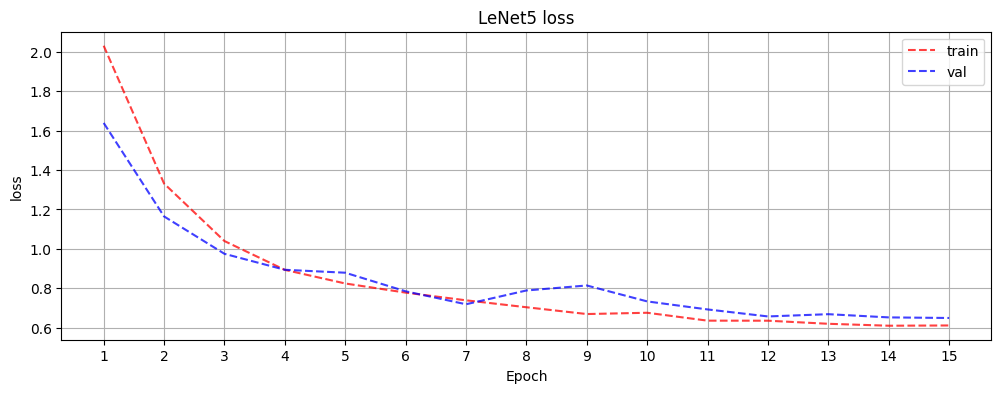

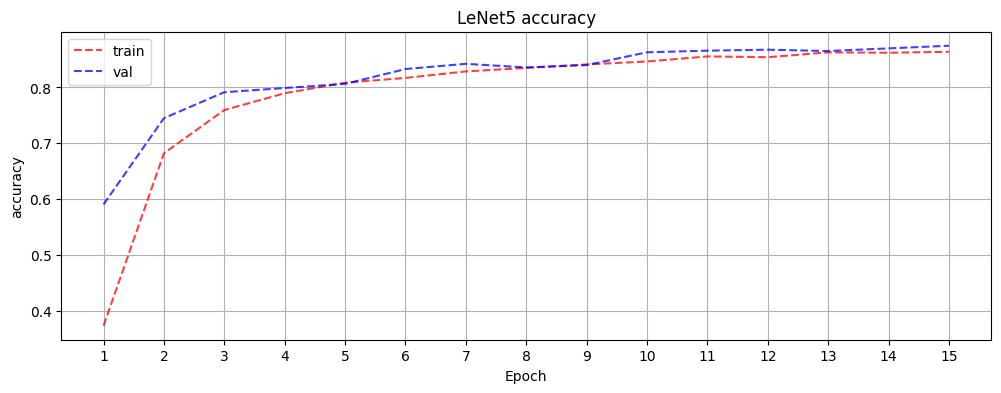

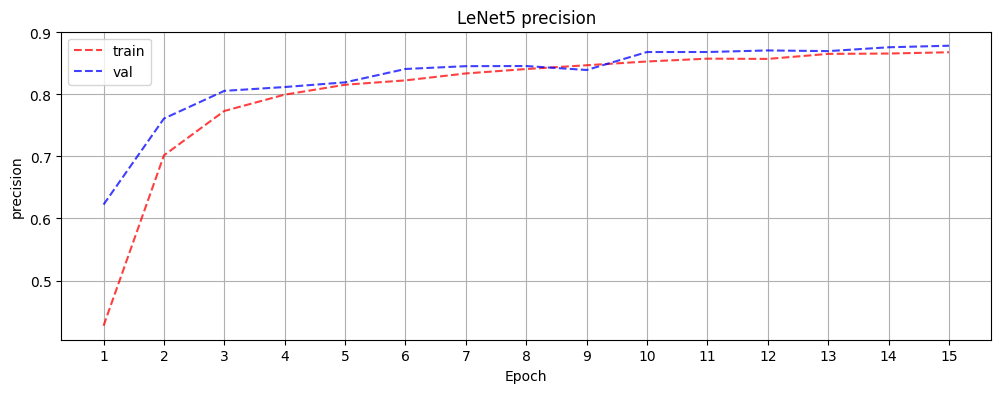

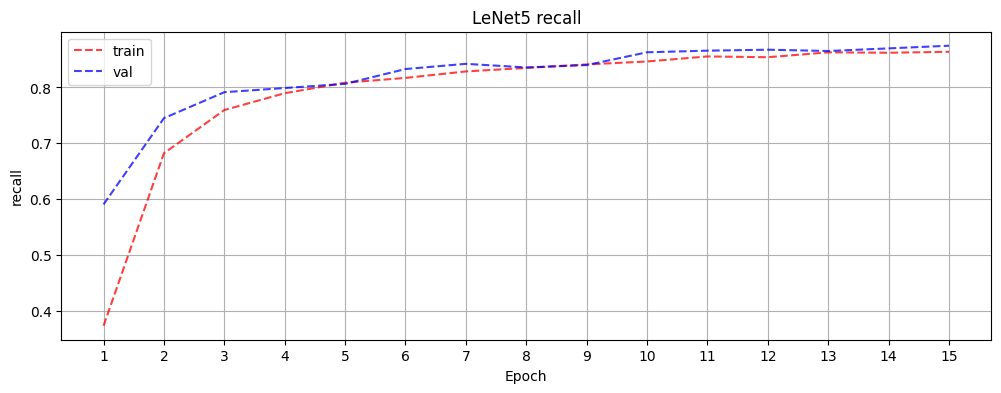

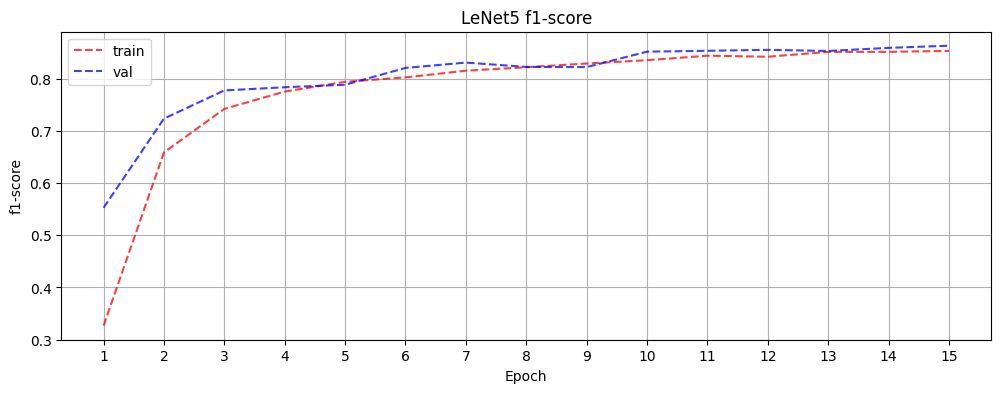

In [16]:
plot_history(history, net_name='LeNet5')

# Evaluate neural network

In [17]:
test_metrics = {
    'accuracy': Accuracy(task='multiclass', num_classes=int(n_classes),
                         average=None).to(device),
    'precision': Precision(task='multiclass', num_classes=int(n_classes),
                           average=None).to(device),
    'recall': Recall(task='multiclass', num_classes=int(n_classes),
                     average=None).to(device),
    'f1-score': F1Score(task='multiclass', num_classes=int(n_classes),
                        average=None).to(device)
}

In [18]:
_, test_metric_values = eval(net, test_dl, prefix='test', criterion=criterion,
                             metrics=test_metrics, device=device)

test_loss: 0.950, test_accuracy: 0.850, test_precision: 0.853, test_recall: 0.850, test_f1-score: 0.837

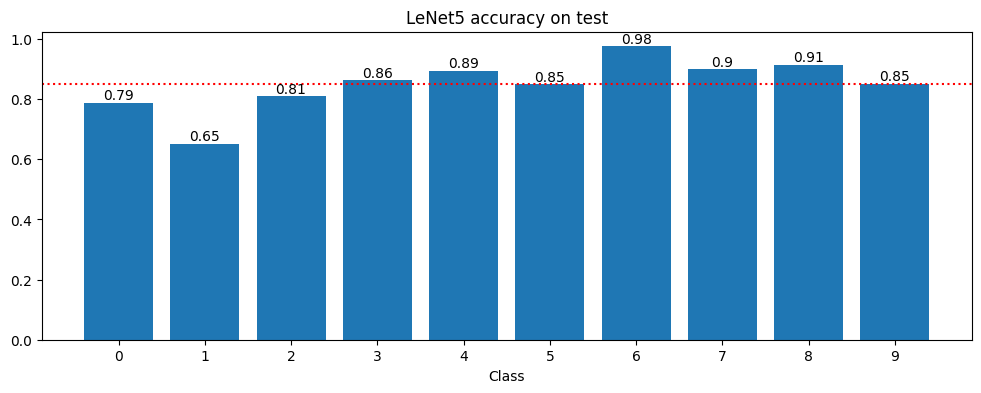

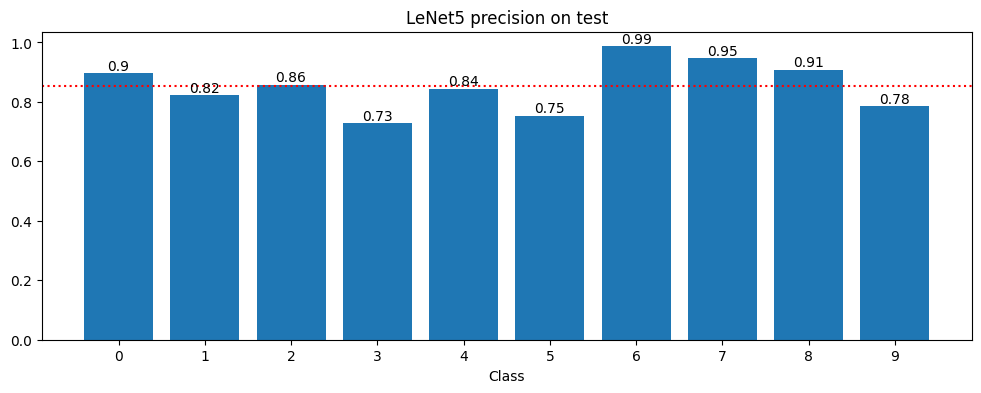

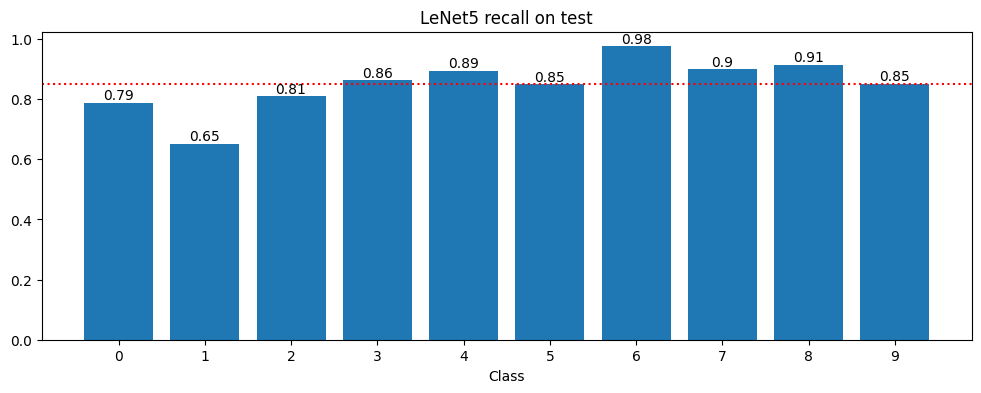

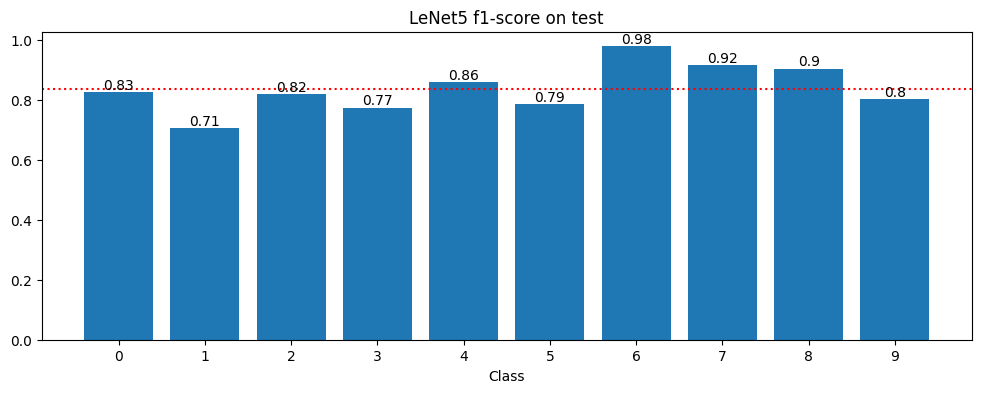

In [19]:
plot_metric_values(test_metric_values, net_name='LeNet5')